# **Import libraries**

In [2]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib

np.random.seed(1)

# **1. Read data**

In [3]:
train_data = pd.read_csv('train.csv')
train_data.head()


,Unnamed: 0,Message ID,Subject,Message,Spam/Ham,split
0,0,0,christmas tree farm pictures,NaN,ham,0.038415
1,1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,0.696509
2,2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,0.587792
3,3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,-0.055438
4,5,5,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham,-0.419658


In [4]:
val_data = pd.read_csv('val.csv')
val_data.head()

,Unnamed: 0,Message ID,Subject,Message,Spam/Ham,split
0,23,23,miscellaneous,- - - - - - - - - - - - - - - - - - - - - - fo...,ham,-0.351998
1,24,24,re : purge of old contract _ event _ status,fyi - what do you all think ?\n- - - - - - - -...,ham,0.257704
2,32,32,valero 8018 and 1394,it is my understanding the outages valero incu...,ham,0.091200
3,37,37,01 / 00 natural gas nomination,enron methanol company nominates the following...,ham,-1.745133
4,43,43,re : misc . questions,- - - - - - - - - - - - - - - - - - - - - - fo...,ham,-1.911987


In [5]:
print(train_data.shape)
print(val_data.shape)

(27284, 6)
(3084, 6)


# **2. Pre-processing**

### 1. Kiểm tra kiểu dữ liệu của đặc trưng

In [6]:
train_data.dtypes

Unnamed: 0      int64
Message ID      int64
Subject        object
Message        object
Spam/Ham       object
split         float64
dtype: object

### 2. Loại bỏ những cột dữ liệu không liên quan

In [7]:
train_data = train_data.drop(['Unnamed: 0', 'split', 'Message ID'], axis=1)
val_data = val_data.drop(['Unnamed: 0', 'split', 'Message ID'], axis=1)
train_data.head()

,Subject,Message,Spam/Ham
0,christmas tree farm pictures,NaN,ham
1,"vastar resources , inc .","gary , production from the high island larger ...",ham
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham
3,re : issue,fyi - see note below - already done .\nstella\...,ham
4,mcmullen gas for 11 / 99,"jackie ,\nsince the inlet to 3 river plant is ...",ham


### 3. Loại bỏ giá trị trùng lặp nhau và chứa giá trị không xác định 

In [8]:
def preprocess(data):
    # data = data.drop_duplicates(subset=['Subject', 'Message'])
    data = data.drop_duplicates(subset=['Message'])
    data = data.drop_duplicates(subset=['Subject'])
    data = data[~(data['Subject'].isnull() & data['Message'].isnull())]
    data = data.fillna('')
    data['Text'] = data['Subject'] + ' ' + data['Message']
    data.drop(['Subject', 'Message'], axis=1, inplace=True)
    data['spam'] = data['Spam/Ham'].apply(lambda x: 1 if x == 'spam' else 0)
    return data


In [9]:
train_data = preprocess(train_data)
print(train_data.shape)
val_data = preprocess(val_data)
print(val_data.shape)

(19721, 3)
(2751, 3)


In [10]:
train_data.head()

,Spam/Ham,Text,spam
0,ham,christmas tree farm pictures,0
1,ham,"vastar resources , inc . gary , production fro...",0
2,ham,calpine daily gas nomination - calpine daily g...,0
3,ham,re : issue fyi - see note below - already done...,0
4,ham,"mcmullen gas for 11 / 99 jackie ,\nsince the i...",0


In [11]:
val_data.head()

,Spam/Ham,Text,spam
0,ham,miscellaneous - - - - - - - - - - - - - - - - ...,0
1,ham,re : purge of old contract _ event _ status fy...,0
2,ham,valero 8018 and 1394 it is my understanding th...,0
3,ham,01 / 00 natural gas nomination enron methanol ...,0
4,ham,re : misc . questions - - - - - - - - - - - - ...,0


### 4. Kiểm tra các sample đã unique hay chưa

In [12]:
train_data[['Spam/Ham', 'Text']].groupby('Spam/Ham').describe()

Text                                                               
          count unique                                                top freq
Spam/Ham                                                                      
ham       10618  10618                      christmas tree farm pictures     1
spam       9103   9103  dobmeos with hgh my energy level has gone up !...    1

# **3. Train model**

### 1. Vector hoá dữ liệu

In [13]:
x_train, x_val, y_train, y_val = train_data.Text, val_data.Text, train_data.spam, val_data.spam

In [14]:
#Build feature vectors from emails
cv = CountVectorizer(ngram_range=(1,2))
x_train_cv = cv.fit_transform(x_train)
x_val_cv = cv.transform(x_val)

In [15]:
x_train_cv.shape

(19721, 1233930)

Accuracy for alpha =  0.1  is  99.45474372955289
Accuracy for alpha =  0.2  is  99.45474372955289
Accuracy for alpha =  0.3  is  99.41839331152308
Accuracy for alpha =  0.4  is  99.38204289349328
Accuracy for alpha =  0.5  is  99.38204289349328
Accuracy for alpha =  0.6  is  99.34569247546347
Accuracy for alpha =  0.7  is  99.34569247546347
Accuracy for alpha =  0.8  is  99.30934205743365
Accuracy for alpha =  0.9  is  99.30934205743365


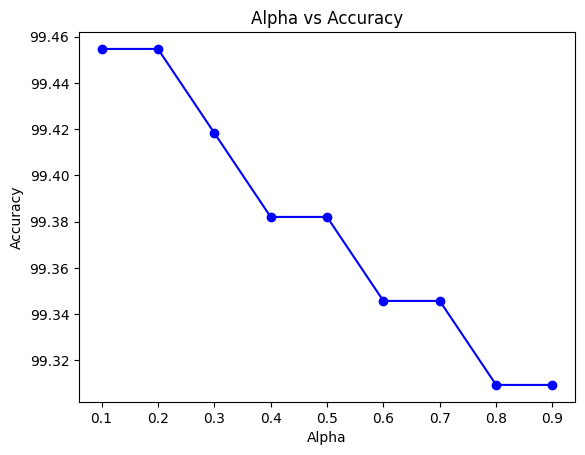

In [16]:
best_alpha = {}
for alpha in range(1, 10):
    alpha /= 10
    model = MultinomialNB(alpha=alpha)
    model.fit(x_train_cv, y_train)
    test_pred = model.predict(x_val_cv)
    accScore = accuracy_score(y_val, test_pred) * 100
    best_alpha[alpha] = accScore
    print("Accuracy for alpha = ", alpha, " is ", accScore)

plt.figure()
plt.plot(list(best_alpha.keys()), list(best_alpha.values()), 'bo-')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Alpha vs Accuracy')
plt.show()

In [18]:
#Predict on validation data/test data
model = MultinomialNB(alpha=max(best_alpha, key=best_alpha.get))
model.fit(x_train_cv, y_train)
y_val_pred = model.predict(x_val_cv)
print("Accuracy = %.2f%%" % (accuracy_score(y_val, y_val_pred) * 100))
print(classification_report(val_data.spam, y_val_pred, digits=4))

Accuracy = 99.45%
              precision    recall  f1-score   support

           0     0.9951    0.9944    0.9948      1433
           1     0.9939    0.9947    0.9943      1318

    accuracy                         0.9945      2751
   macro avg     0.9945    0.9946    0.9945      2751
weighted avg     0.9945    0.9945    0.9945      2751



# Save Model

In [44]:
joblib.dump(model, 'spam_classifier.pkl')
joblib.dump(cv, 'spam_vectorizer.pkl')

['spam_vectorizer.pkl']

# **4. Experiments**

In [20]:
email = ["Hello, I hope you are doing well. This is a reminder for our meeting tomorrow at 10 AM. Please let me know if you need to reschedule. Best, John"]
spam_email = ["Congratulations! You've won a $1,000 gift card. Click here to claim your prize now!"]

print("spam" if model.predict(cv.transform(email))[0] == 1 else "ham")
print("spam" if model.predict(cv.transform(spam_email))[0] == 1 else "ham") 

ham
spam
